In [1]:
import pandas as pd
import geopandas as gpd
import utils
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

In [2]:
# Read data and generate parameters
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)
age_group_flow_scaling = utils.get_age_group_flow_scaling(config.age_bins, age_labels, population)
commuters = utils.generate_commuter_matrix(age_group_flow_scaling)

In [3]:
# load geospatial data
gdf = utils.generate_geopandas(population, paths.municipalities_geo)

In [4]:
gdf['center'] = gdf.centroid

In [5]:
gdf

region_id                                           geometry  population  \
0         301  MULTIPOLYGON (((1195545.227 8376842.467, 11949...      696780   
1        1101  MULTIPOLYGON (((657293.673 8062697.051, 657846...       14785   
2        1103  MULTIPOLYGON (((649061.048 8175099.470, 649312...      144115   
3        1106  MULTIPOLYGON (((565770.547 8278065.858, 566736...       37312   
4        1108  MULTIPOLYGON (((650437.703 8170314.157, 648515...       80445   
..        ...                                                ...         ...   
352      5440  MULTIPOLYGON (((3266309.544 11298063.866, 3256...         928   
353      5441  MULTIPOLYGON (((2942108.723 11102143.757, 2974...        2828   
354      5442  MULTIPOLYGON (((3151814.537 11087449.545, 3150...         880   
355      5443  MULTIPOLYGON (((3362801.357 11179433.616, 3347...        2200   
356      5444  MULTIPOLYGON (((3416411.017 10991795.539, 3428...       10101   

      region_name                            center  
0            OSLO   POINT (1195521.962 8395962.539)  
1       EIGERSUND    POINT (684385.743 8073883.792)  
2       STAVANGER    POINT (647167.699 8204786.424)  
3       HAUGESUND    POINT (590542.952 8276713.912)  
4         SANDNES    POINT (703575.130 8175982.541)  
..            ...                               ...  
352      BERLEVÅG  POINT (3231836.384 11294377.080)  
353          TANA  POINT (3076472.979 11140405.368)  
354       NESSEBY  POINT (3203350.317 11114222.046)  
355     BÅTSFJORD  POINT (3332171.268 11233572.399)  
356  SØR-VARANGER  POINT (3298181.044 10950445.736)  

[357 rows x 5 columns]

In [6]:
gdf['region_id'] = gdf['region_id'].astype('str')
gdf['region_id'] = gdf['region_id'].apply(lambda x: '{0:0>4}'.format(x))
gdf

region_id                                           geometry  population  \
0        0301  MULTIPOLYGON (((1195545.227 8376842.467, 11949...      696780   
1        1101  MULTIPOLYGON (((657293.673 8062697.051, 657846...       14785   
2        1103  MULTIPOLYGON (((649061.048 8175099.470, 649312...      144115   
3        1106  MULTIPOLYGON (((565770.547 8278065.858, 566736...       37312   
4        1108  MULTIPOLYGON (((650437.703 8170314.157, 648515...       80445   
..        ...                                                ...         ...   
352      5440  MULTIPOLYGON (((3266309.544 11298063.866, 3256...         928   
353      5441  MULTIPOLYGON (((2942108.723 11102143.757, 2974...        2828   
354      5442  MULTIPOLYGON (((3151814.537 11087449.545, 3150...         880   
355      5443  MULTIPOLYGON (((3362801.357 11179433.616, 3347...        2200   
356      5444  MULTIPOLYGON (((3416411.017 10991795.539, 3428...       10101   

      region_name                            center  
0            OSLO   POINT (1195521.962 8395962.539)  
1       EIGERSUND    POINT (684385.743 8073883.792)  
2       STAVANGER    POINT (647167.699 8204786.424)  
3       HAUGESUND    POINT (590542.952 8276713.912)  
4         SANDNES    POINT (703575.130 8175982.541)  
..            ...                               ...  
352      BERLEVÅG  POINT (3231836.384 11294377.080)  
353          TANA  POINT (3076472.979 11140405.368)  
354       NESSEBY  POINT (3203350.317 11114222.046)  
355     BÅTSFJORD  POINT (3332171.268 11233572.399)  
356  SØR-VARANGER  POINT (3298181.044 10950445.736)  

[357 rows x 5 columns]

In [7]:
df = pd.read_csv(paths.municipalities_commuters)
commuters = df.pivot(columns='to', index='from', values='n').fillna(0).values
df['from'] = df['from'].str.replace(r'\D', '')
df['to'] = df['to'].str.replace(r'\D', '')
df['to'] = df['to'].str.replace(r'\D', '')
df

<ipython-input-7-a6fc13aa1035>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['from'] = df['from'].str.replace(r'\D', '')
<ipython-input-7-a6fc13aa1035>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['to'] = df['to'].str.replace(r'\D', '')
<ipython-input-7-a6fc13aa1035>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['to'] = df['to'].str.replace(r'\D', '')


from    to      n
0      0301  4638    8.0
1      0301  1875    2.0
2      0301  5055    2.0
3      0301  3001  149.0
4      0301  3002  595.0
...     ...   ...    ...
23947  5444  5421    1.0
23948  5444  3019    1.0
23949  5444  5441   49.0
23950  5444  1871    1.0
23951  5444  3025    1.0

[23952 rows x 3 columns]

In [8]:
df2 = df.merge(gdf, how='left', left_on='from', right_on='region_id')
df2 = df2[['from', 'to', 'n', 'center']]
df2 = df2.rename(columns={'center': 'from_geo'})

df2 = df2.merge(gdf, how='left', left_on='to', right_on='region_id')
df2 = df2[['from', 'to', 'n', 'from_geo', 'center']]
df2 = df2.rename(columns={'center': 'to_geo'})
df2

from    to      n                          from_geo  \
0      0301  4638    8.0   POINT (1195521.962 8395962.539)   
1      0301  1875    2.0   POINT (1195521.962 8395962.539)   
2      0301  5055    2.0   POINT (1195521.962 8395962.539)   
3      0301  3001  149.0   POINT (1195521.962 8395962.539)   
4      0301  3002  595.0   POINT (1195521.962 8395962.539)   
...     ...   ...    ...                               ...   
24527  5444  5421    1.0  POINT (3298181.044 10950445.736)   
24528  5444  3019    1.0  POINT (3298181.044 10950445.736)   
24529  5444  5441   49.0  POINT (3298181.044 10950445.736)   
24530  5444  1871    1.0  POINT (3298181.044 10950445.736)   
24531  5444  3025    1.0  POINT (3298181.044 10950445.736)   

                                 to_geo  
0        POINT (659334.616 8657622.974)  
1      POINT (1800928.658 10420287.007)  
2        POINT (990883.281 9156318.344)  
3       POINT (1279848.707 8199322.519)  
4       POINT (1192722.269 8269923.018)  
...                                 ...  
24527  POINT (1960644.069 10850736.289)  
24528   POINT (1195210.398 8304764.342)  
24529  POINT (3076472.979 11140405.368)  
24530  POINT (1756220.761 10767777.124)  
24531   POINT (1164380.016 8334612.177)  

[24532 rows x 5 columns]

In [9]:
 df2['line'] = None

In [10]:
l = []
for index, row in df2.iterrows():
    if df2['to_geo'][index].is_empty or  df2['from_geo'][index].is_empty :
        l.append(False)
    else:
        l.append(True)

In [11]:
df2 = df2[l]

In [12]:
for index, row in df2.iterrows():
    df2['line'][index] = LineString([df2['from_geo'][index], df2['to_geo'][index]])

<ipython-input-12-5243a2a658e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['line'][index] = LineString([df2['from_geo'][index], df2['to_geo'][index]])
C:\Users\Peder\Anaconda3\envs\epidemics_7\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
gdf2 = gpd.GeoDataFrame(df2, geometry=df2['line'])

In [14]:
gdf2

from    to      n                          from_geo  \
0      0301  4638    8.0   POINT (1195521.962 8395962.539)   
1      0301  1875    2.0   POINT (1195521.962 8395962.539)   
2      0301  5055    2.0   POINT (1195521.962 8395962.539)   
3      0301  3001  149.0   POINT (1195521.962 8395962.539)   
4      0301  3002  595.0   POINT (1195521.962 8395962.539)   
...     ...   ...    ...                               ...   
24527  5444  5421    1.0  POINT (3298181.044 10950445.736)   
24528  5444  3019    1.0  POINT (3298181.044 10950445.736)   
24529  5444  5441   49.0  POINT (3298181.044 10950445.736)   
24530  5444  1871    1.0  POINT (3298181.044 10950445.736)   
24531  5444  3025    1.0  POINT (3298181.044 10950445.736)   

                                 to_geo  \
0        POINT (659334.616 8657622.974)   
1      POINT (1800928.658 10420287.007)   
2        POINT (990883.281 9156318.344)   
3       POINT (1279848.707 8199322.519)   
4       POINT (1192722.269 8269923.018)   
...                                 ...   
24527  POINT (1960644.069 10850736.289)   
24528   POINT (1195210.398 8304764.342)   
24529  POINT (3076472.979 11140405.368)   
24530  POINT (1756220.761 10767777.124)   
24531   POINT (1164380.016 8334612.177)   

                                                    line  \
0      LINESTRING (1195521.962495824 8395962.53914720...   
1      LINESTRING (1195521.962495824 8395962.53914720...   
2      LINESTRING (1195521.962495824 8395962.53914720...   
3      LINESTRING (1195521.962495824 8395962.53914720...   
4      LINESTRING (1195521.962495824 8395962.53914720...   
...                                                  ...   
24527  LINESTRING (3298181.043622201 10950445.7364465...   
24528  LINESTRING (3298181.043622201 10950445.7364465...   
24529  LINESTRING (3298181.043622201 10950445.7364465...   
24530  LINESTRING (3298181.043622201 10950445.7364465...   
24531  LINESTRING (3298181.043622201 10950445.7364465...   

                                                geometry  
0      LINESTRING (1195521.962 8395962.539, 659334.61...  
1      LINESTRING (1195521.962 8395962.539, 1800928.6...  
2      LINESTRING (1195521.962 8395962.539, 990883.28...  
3      LINESTRING (1195521.962 8395962.539, 1279848.7...  
4      LINESTRING (1195521.962 8395962.539, 1192722.2...  
...                                                  ...  
24527  LINESTRING (3298181.044 10950445.736, 1960644....  
24528  LINESTRING (3298181.044 10950445.736, 1195210....  
24529  LINESTRING (3298181.044 10950445.736, 3076472....  
24530  LINESTRING (3298181.044 10950445.736, 1756220....  
24531  LINESTRING (3298181.044 10950445.736, 1164380....  

[23952 rows x 7 columns]

<AxesSubplot:>

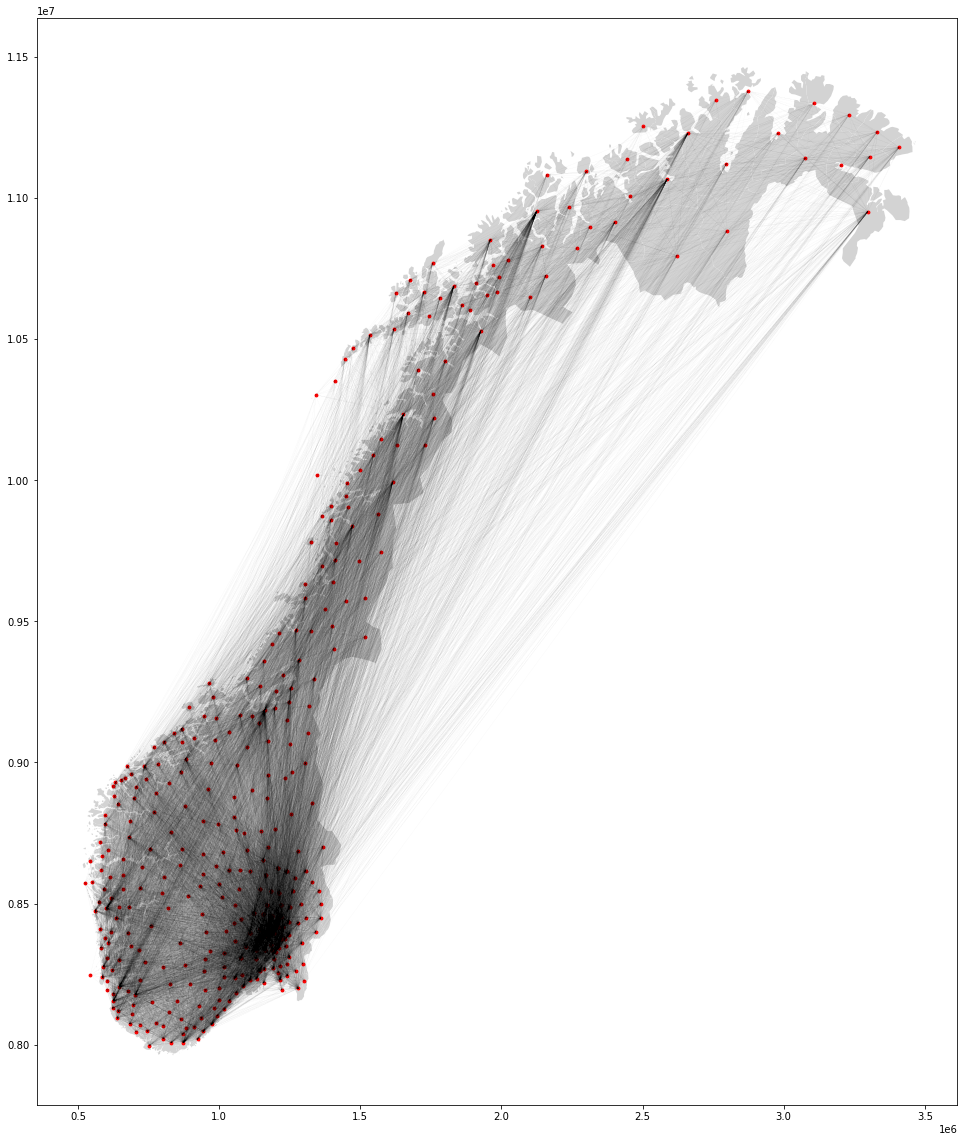

In [15]:
fig, ax1 = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax1, color='lightgrey')
gdf2.plot(ax=ax1, color='black', linewidth=0.01)
gdf['center'].plot(ax=ax1, color='red', markersize=8)